# NPS - CB1 - Machine learning 

# Setup
## Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
import pickle
import random

# Modelling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
import xgboost as xgb
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from molvs import standardize_smiles


# Visualisation
import matplotlib.pyplot as plt
import math
import seaborn as sns
from matplotlib import colors as plt_colors

from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.SimDivFilters import MaxMinPicker
from rdkit.Chem import rdDepictor,rdMolTransforms
import math
import shap

# Molpipeline
from molpipeline.abstract_pipeline_elements.mol2any.mol2bitvector import MolToFingerprintPipelineElement
from molpipeline import Pipeline
from molpipeline.any2mol import AutoToMol
from molpipeline.mol2any import MolToMorganFP
from molpipeline.experimental.explainability import SHAPTreeExplainer
from molpipeline.experimental.explainability import (
    structure_heatmap_shap,
)
from molpipeline.mol2mol import (
    ElementFilter,
    SaltRemover,
)

from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png
from rdkit_heatmaps import get_depiction_limits
from IPython.display import display
from PIL import Image as PILImage
from PIL import Image
import io
from rdkit.Chem.Draw import MolDraw2DCairo


## Functions

In [ ]:
def diversity_train_test_split(df, strat_size=0.8, outcome='y'):
    mfpgen = GetMorganGenerator(radius=2, fpSize=2048)
    mmp = MaxMinPicker()

    selected_indices = []

    for label in df[outcome].unique():
        df_sub = df[df[outcome] == label].copy()
        
        fps = []
        mol_list = []
        idx_list = []

        for idx, row in df_sub.iterrows():
            mol = Chem.MolFromSmiles(row['smiles'])
            if mol is None:
                continue
            fp = mfpgen.GetFingerprint(mol)
            fps.append(fp)
            mol_list.append(mol)
            idx_list.append(idx)

        n_total = len(fps)
        n_pick = math.floor(strat_size * n_total)

        if n_total >= n_pick and n_pick > 0:
            idx_list = list(df_sub.index) 
            bv_ids = mmp.LazyBitVectorPick(fps, len(fps), n_pick)
            selected_indices.extend([idx_list[i] for i in bv_ids])

    selected_indices = list(selected_indices)

    remaining_indices = list(set(df.index) - set(selected_indices))

    X_train = df.loc[selected_indices].drop([outcome, 'smiles'], axis=1).copy()
    X_test = df.loc[remaining_indices].drop([outcome, 'smiles'], axis=1).copy()
    y_train = df.loc[selected_indices][outcome].copy()
    y_test = df.loc[remaining_indices][outcome].copy()
    
    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train=le.transform(y_train)
    y_test=le.transform(y_test)

    return X_train, X_test, y_train, y_test

# def outcome_11(df_ki_orig):    
#     df_ki = df_ki_orig.copy()

#     df_ki = df_ki.loc[~((df_ki['value'] < 10000) & (df_ki['qualifier'] == ">"))] 

#     df_ki['value'] = df_ki['value'].fillna(50000)
#     df_ki = df_ki.loc[df_ki.groupby('smiles')['value'].idxmin()] 

#     conditions = [
#         (df_ki['value'] <10),   
#         (df_ki['value'] >= 100) & (df_ki['value']<1000),
#         (df_ki['value'] >= 4000)
#     ]

#     values = [
#         2, 
#         1,    
#         0 
#     ]

#     df_ki['y'] = np.select(conditions, values, default=None)
#     df_ki = df_ki.dropna(subset='y')

#     del conditions, values
    
#     return df_ki


def my_diverse_random_forest_model(df_orig):
    df = df_orig.drop(['outcome', 'qualifier', 'value', 'endpoint', 'substance_added','cell_membrane',
                       'receptor_species', 'reference_substance', 'incubation_time','temp'], 
                      axis=1).copy()
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}
    
    rf = RandomForestClassifier(class_weight=class_weight)
    rf.fit(X_train, y_train_encoded)
       
    return rf, X_train, X_test, y_train_encoded, y_test_encoded, label_encoder

# def outcome_ec_5 (df_ki_orig):
    
#     df_ki = df_ki_orig.copy()
    
#     df_ki = df_ki[~df_ki.outcome.str.contains("Unspecified", na=False, case=False)]
#     df_ki = df_ki[~df_ki.outcome.str.contains("Inconclusive", na=False, case=False)]
    
#     df_ki = df_ki.loc[~((df_ki['value'] < 5000) & (df_ki['qualifier'] == ">"))] 

#     df_ki['value'] = df_ki['value'].fillna(50000)
#     df_ki = df_ki.loc[df_ki.groupby('smiles')['value'].idxmin()] 
#     df_ki = df_ki[df_ki['value']!=50000] 
    
#     conditions = [ 
#         (df_ki['outcome'] == 'Inactive'), 
#         (df_ki['value'] <50),   
#         (df_ki['value'] >= 200) & (df_ki['value']<2000),
#         (df_ki['value'] >= 6000)
#     ]

#     values = [
#         0, 
#         2, 
#         1, 
#         0 
#     ]

#     df_ki['y'] = np.select(conditions, values, default=None)
    
#     df_ki = df_ki.dropna(subset='y')

#     del conditions, values
    
#     return df_ki

def my_diverse_xgboost(df_orig, model, my_index):
    df = df_orig.drop(['outcome', 'qualifier', 'value', 'endpoint', 'substance_added','cell_membrane',
                       'receptor_species', 'reference_substance', 'incubation_time','temp'], 
                      axis=1).copy()
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    classes = np.unique(y_train)
    cl_wght = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weight = {classes[i]: cl_wght[i] for i in range(len(classes))}
    
    sample_weights = np.array([class_weight[y] for y in y_train])
    
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
    xgb_model.fit(X_train, y_train, sample_weight = sample_weights)
    
    y_pred = xgb_model.predict(X_train)
    
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = xgb_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted")    

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train, 
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',  
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])  
    
    return df_result

def my_diverse_random_forest(df_orig, model, my_index):
    df = df_orig.drop(['outcome', 'qualifier', 'value', 'endpoint', 'substance_added','cell_membrane',
                       'receptor_species', 'reference_substance', 'incubation_time','temp'], 
                      axis=1).copy()
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}
    
    rf = RandomForestClassifier(class_weight=class_weight)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_train)
    
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = rf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted")

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train, 
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',   
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])   
    
    return df_result

def my_diverse_svm(df_orig, model, my_index, scale=False):
    df = df_orig.drop(['outcome', 'qualifier', 'value', 'endpoint', 'substance_added','cell_membrane',
                       'receptor_species', 'reference_substance', 'incubation_time','temp'], 
                      axis=1).copy()
    
    df = df.dropna(axis=0) 
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    if scale:
      scaler = preprocessing.StandardScaler().fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)
    
    cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}
    
    mysvm = svm.SVC(decision_function_shape='ovo', class_weight=class_weight, probability=True)
    mysvm.fit(X_train, y_train)
    
    y_pred = mysvm.predict(X_train)

    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = mysvm.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted") 

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train, 
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',  
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])  
    
    return df_result

def my_diverse_mlp(df_orig, model, my_index, scale=False):
    df = df_orig.drop(['outcome', 'qualifier', 'value', 'endpoint', 'substance_added','cell_membrane',
                       'receptor_species', 'reference_substance', 'incubation_time','temp'], 
                      axis=1).copy()
    
    df = df.dropna(axis=0)
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    if scale:
      scaler = preprocessing.StandardScaler().fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)
    
    cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}
    
    params = {'hidden_layer_sizes' : [10,10],
          'activation' : 'relu', 'solver' : 'adam',
          'alpha' : 0.0, 'batch_size' : 10,
          'random_state' : 1,'tol' : 0.0001,
          'nesterovs_momentum' : False,
          'learning_rate' : 'constant',
          'learning_rate_init' : 0.01,
          'max_iter' : 1000, 'shuffle' : True,
          'n_iter_no_change' : 90, 'verbose' : False }

    net = MLPClassifier(**params)
    
    net.fit(X_train, y_train)
    
    y_pred = net.predict(X_train)
    
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = net.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted") 

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train, 
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',  
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])  
    
    return df_result

def my_diverse_lr(df_orig, model, my_index, scale=False):
    df = df_orig.drop(['outcome', 'qualifier', 'value', 'endpoint', 'substance_added','cell_membrane',
                       'receptor_species', 'reference_substance', 'incubation_time','temp'], 
                      axis=1).copy()
    
    df = df.dropna(axis=0)
       
    X_train, X_test, y_train, y_test = diversity_train_test_split(df)
    
    if scale:
      scaler = preprocessing.StandardScaler().fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)
    
    cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}
    
    lr = LogisticRegression(solver='lbfgs', class_weight=class_weight, random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_train)    
    f1_train = f1_score(y_train, y_pred, average="weighted")
    precision_train = precision_score(y_train, y_pred, average="weighted")
    recall_train = recall_score(y_train, y_pred, average="weighted")
    
    y_pred = lr.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    f1_test = f1_score(y_test, y_pred, average="weighted")
    precision_test = precision_score(y_test, y_pred, average="weighted")
    recall_test = recall_score(y_test, y_pred, average="weighted") 

    df_result = pd.DataFrame([[model, f1_train, precision_train, recall_train,
                           f1_test, precision_test, recall_test 
                           ]],  
                         columns=['model', 
                                  'f1_train', 'precision_train', 'recall_train',  
                                  'f1_test', 'precision_test', 'recall_test'
                                  ],
                         index=[my_index])  
    
    return df_result

def diversity_train_test_split2(df, strat_size=0.8, outcome='y'):

    mfpgen = GetMorganGenerator(radius=2, fpSize=2048)
    mmp = MaxMinPicker()

    selected_indices = []

    for label in df[outcome].unique():
        df_sub = df[df[outcome] == label].copy()
        
        fps = []
        mol_list = []
        idx_list = []

        for idx, row in df_sub.iterrows():
            mol = Chem.MolFromSmiles(row['smiles'])
            if mol is None:
                continue
            fp = mfpgen.GetFingerprint(mol)
            fps.append(fp)
            mol_list.append(mol)
            idx_list.append(idx)

        n_total = len(fps)
        n_pick = math.floor(strat_size * n_total)

        if n_total >= n_pick and n_pick > 0:
            idx_list = list(df_sub.index)  
            bv_ids = mmp.LazyBitVectorPick(fps, len(fps), n_pick)
            selected_indices.extend([idx_list[i] for i in bv_ids])

    selected_indices = list(selected_indices)

    remaining_indices = list(set(df.index) - set(selected_indices))
    X_train = df.loc[selected_indices]['smiles'].copy()
    X_test = df.loc[remaining_indices]['smiles'].copy()
    y_train = df.loc[selected_indices][outcome].copy()
    y_test = df.loc[remaining_indices][outcome].copy()
    
    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train=le.transform(y_train)
    y_test=le.transform(y_test)

    return X_train, X_test, y_train, y_test

def shuffle(x):
    x = list(x)
    random.shuffle(x)
    return x


# Binding affinity (Ki)
## Import datasets

In [ ]:

# with open("orig_dataframes_cb1_ki.pkl", "rb") as f:
#     loaded = pickle.load(f)

# df_ki_orig = loaded["df_ki_orig"]
# df_maccs_orig = loaded["df_maccs_orig"]
# df_ecfp_orig = loaded["df_ecfp_orig"]
# df_kr_orig = loaded["df_kr_orig"]

# df_ki = outcome_11(df_ki_orig)
# df_maccs = outcome_11(df_maccs_orig)
# df_ecfp = outcome_11(df_ecfp_orig)
# df_kr = outcome_11(df_kr_orig)


In [3]:
# save model

# ## pickel the df's
# import pickle
# # Wrap them in a dictionary
# dataframes = {
#     "df_ki": df_ki, #this is the padel dataset
#     "df_maccs": df_maccs,
#     "df_ecfp": df_ecfp,
#     "df_kr": df_kr 
# }

# Save to file
# with open("dataframes_cb1_ki.pkl", "wb") as f:
#     pickle.dump(dataframes, f)
    
with open("dataframes_cb1_ki.pkl", "rb") as f:
    loaded = pickle.load(f)

df_ki = loaded["df_ki"]
df_maccs = loaded["df_maccs"]
df_ecfp = loaded["df_ecfp"]
df_kr = loaded["df_kr"]

## Model comparison

### XGBoost

In [ ]:
df_1 = my_diverse_xgboost(df_ki, 'padel', 'XGBoost')
df_2 = my_diverse_xgboost(df_ecfp, 'ecfp', 'XGBoost')
df_3 = my_diverse_xgboost(df_maccs, 'maccs', 'XGBoost')
df_4 = my_diverse_xgboost(df_kr, 'KlekotaRoth', 'XGBoost')

df_final_xgb = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Random Forest

In [ ]:
df_1 = my_diverse_random_forest(df_ki, 'padel', 'RandomForest')
df_2 = my_diverse_random_forest(df_ecfp, 'ecfp', 'RandomForest')
df_3 = my_diverse_random_forest(df_maccs, 'maccs', 'RandomForest')
df_4 = my_diverse_random_forest(df_kr, 'KlekotaRoth', 'RandomForest')

df_final_rf = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### SVM

In [ ]:
df_1 = my_diverse_svm(df_ki, 'padel', 'SVM', scale=True)
df_2 = my_diverse_svm(df_ecfp, 'ecfp', 'SVM')
df_3 = my_diverse_svm(df_maccs, 'maccs', 'SVM')
df_4 = my_diverse_svm(df_kr, 'KlekotaRoth', 'SVM')

df_final_svm = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### MLP

In [ ]:
df_1 = my_diverse_mlp(df_ki, 'padel', 'MLP', scale=True)
df_2 = my_diverse_mlp(df_ecfp, 'ecfp', 'MLP')
df_3 = my_diverse_mlp(df_maccs, 'maccs', 'MLP')
df_4 = my_diverse_mlp(df_kr, 'KlekotaRoth', 'MLP')

df_final_mlp = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Logistic regression

In [ ]:
df_1 = my_diverse_lr(df_ki, 'padel', 'LR', scale=True)
df_2 = my_diverse_lr(df_ecfp, 'ecfp', 'LR')
df_3 = my_diverse_lr(df_maccs, 'maccs', 'LR')
df_4 = my_diverse_lr(df_kr, 'KlekotaRoth', 'LR')

df_final_lr = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

## Combine

In [ ]:
df_final_models = pd.concat([df_final_xgb, df_final_rf, df_final_svm, df_final_mlp, df_final_lr])

## y-randomization

In [ ]:
df_ki_rand = df_ki
df_ki_rand['y'] = shuffle(df_ki["y"])

df_maccs_rand = df_maccs
df_maccs_rand['y'] = shuffle(df_maccs["y"])

df_ecfp_rand = df_ecfp
df_ecfp_rand['y'] = shuffle(df_ecfp["y"])

df_kr_rand = df_kr
df_kr_rand['y'] = shuffle(df_kr["y"])

In [ ]:
df_1 = my_diverse_xgboost(df_ki_rand, 'padel', 'XGBoost')
df_2 = my_diverse_xgboost(df_ecfp_rand, 'ecfp', 'XGBoost')
df_3 = my_diverse_xgboost(df_maccs_rand, 'maccs', 'XGBoost')
df_4 = my_diverse_xgboost(df_kr_rand, 'KlekotaRoth', 'XGBoost')

df_final_xgb = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

## SHAP

In [ ]:
with open("model_ki_xgb_ki.pkl", "rb") as f:
    loaded = pickle.load(f)

model = loaded["model"]
X_train = loaded["X_train"]
X_test = loaded["X_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
label_encoder = loaded["label_encoder"]

In [ ]:

explainer = shap.Explainer(model, X_train, algorithm="tree")
shap_values = explainer(X_test)

### Summary Plot

In [ ]:
colors = ["silver", "gray", "black"]
classes = ["no affinity", "low affinity", "high affinity"]

class_inds = np.argsort(classes)

cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

shap.summary_plot(shap_values, X_test.values, max_display=10, class_names=["no affinity", "low affinity", "high affinity"], class_inds=[0, 1, 2], plot_type="bar", 
                  color = cmap, show=False)



### Beeswarm

In [ ]:
shap_values_class0 = shap_values[:, :, 0]  
shap_values_class1 = shap_values[:, :, 1] 
shap_values_class2 = shap_values[:, :, 2] 

my_classes = [shap_values_class0, shap_values_class1, shap_values_class2]
titles = ["A. No affinity", "B. Low affinity", "C. High affintiy"]

fig, axes = plt.subplots(3, 1, figsize=(9, 12), dpi=300)

for i, (ax, expl, title) in enumerate(zip(axes, my_classes, titles)):
    shap.plots.beeswarm(
        expl,
        max_display=10,
        group_remaining_features=False,
        show=False,
        plot_size=None, 
        ax=ax     
    )
    ax.set_title(title, loc="center", pad=15, fontweight="bold", fontsize=14)
    
    if i < len(axes) - 1:
        ax.set_xlabel("") 

plt.tight_layout()

plt.subplots_adjust(hspace=0.4)

plt.show()

## SHAP heatmap

In [ ]:
# with open("orig_dataframes_cb1_ki.pkl", "rb") as f:
#     loaded = pickle.load(f)

# df_ki_orig = loaded["df_ki_orig"]
# df_maccs_orig = loaded["df_maccs_orig"]
# df_ecfp_orig = loaded["df_ecfp_orig"]
# df_kr_orig = loaded["df_kr_orig"]

# df_ki = outcome_11(df_ki_orig)
# df_maccs = outcome_11(df_maccs_orig)
# df_ecfp = outcome_11(df_ecfp_orig)
# df_kr = outcome_11(df_kr_orig)

with open("dataframes_cb1_ki.pkl", "rb") as f:
    loaded = pickle.load(f)

df_ki = loaded["df_ki"]
df_maccs = loaded["df_maccs"]
df_ecfp = loaded["df_ecfp"]
df_kr = loaded["df_kr"]

X = df_ecfp['smiles'].copy()
y = df_ecfp['y'].copy()

le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}

pipeline = Pipeline([
    ("auto2mol", AutoToMol()),
    ("morgan3_2048", MolToMorganFP(n_bits=2048, radius=3)),
    ("RandomForest", RandomForestClassifier(random_state=42, class_weight=class_weight))
],
    n_jobs=4)

pipeline.fit(X, y)

### Functions

In [ ]:

def plot_molecule_shap2(mol, pipeline=pipeline, pad=12, value_lims=None):

    explainer = SHAPTreeExplainer(pipeline)
    explanations = explainer.explain([mol], check_additivity=False)
    exp = explanations[0]

    atom_weights = exp.atom_weights

    if value_lims is None:
        local_min = atom_weights.min()
        local_max = atom_weights.max()
        local_abs = max(abs(local_min), abs(local_max))
        value_lims = [-local_abs, local_abs]

    canvas = mapvalues2mol(mol, atom_weights, value_lims=value_lims)
    img = transform2png(canvas.GetDrawingText())

    buf = io.BytesIO()
    img.save(buf, format="PNG")
    cropped = crop_to_content(buf.getvalue(), pad=pad)

    pred_class = pipeline.predict([mol])[0]
    proba = pipeline.predict_proba([mol])[0]
    confidence = proba[pred_class] * 100

    class_map = {
        2: "High affinity",
        1: "Low affinity",
        0: "No affinity"
    }
    pred_label = class_map.get(pred_class, str(pred_class))

    fw = exp.feature_weights
    class_feat_shap = fw[:, pred_class].sum()

    return cropped, pred_label, confidence, class_feat_shap


def crop_to_content(png_bytes, pad=15, white_threshold=250):

    img = Image.open(io.BytesIO(png_bytes)).convert("RGBA")
    arr = np.asarray(img)
    alpha = arr[:, :, 3]
    rgb = arr[:, :, :3]

    content_mask = (alpha > 0) & (np.any(rgb < white_threshold, axis=2))

    if not content_mask.any():
        return img 

    ys, xs = np.where(content_mask)
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()

    x0 = max(x0 - pad, 0)
    y0 = max(y0 - pad, 0)
    x1 = min(x1 + pad, img.width - 1)
    y1 = min(y1 + pad, img.height - 1)

    return img.crop((x0, y0, x1 + 1, y1 + 1))


### Combined plot

In [ ]:
df_simis = pd.read_csv('cb1_similarity_substances.csv', sep=";")

pretty_names = {
    "JWH_018": "JWH-018",
    "2_OH_indole_JWH_018": "2-OH indole JWH-018",
    "4_OH_indole_JWH_018": "4-OH indole JWH-018",
    "5_OH_indole_JWH_018": "5-OH indole JWH-018",
    "6_OH_indole_JWH_018": "6-OH indole JWH-018",
    "7_OH_indole_JWH_018": "7-OH indole JWH-018",
    "4_OH_pentyl_JWH_018" : "4-OH pentyl JWH-018", 
    "5_OH_pentyl_JWH_018" : "5-OH pentyl JWH-018", 
    "N_Pentanoic_acid_JWH_018" : "N-Pentanoic acid JWH-018",
    "THJ_2201": "THJ-2201", 
    "AM_2201" : "AM-2201", 
    "THJ_018" : "THJ-018"
}


In [ ]:
mols = [Chem.MolFromSmiles(s) for s in df_simis["smiles"]]
for mol, name in zip(mols, df_simis["names"]):
    mol.SetProp("names", str(name))

explainer = SHAPTreeExplainer(pipeline)
explanations = explainer.explain(mols, check_additivity=False)

explanations_dict = {exp.molecule.GetProp("names"): exp for exp in explanations}

weight_min = min(exp.atom_weights.min() for exp in explanations_dict.values())
weight_max = max(exp.atom_weights.max() for exp in explanations_dict.values())
weight_abs_max = max(abs(weight_min), abs(weight_max))

weight_abs_max *= 0.70

global_limits = [-weight_abs_max, weight_abs_max]

In [ ]:

rotate = ["5_OH_pentyl_JWH_018", "N_Pentanoic_acid_JWH_018","THJ_2201", "AM_2201"]

mols = {}
rot_y = np.array([[-1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,-1.,0.],[0.,0.,0.,1.]])

for smi, name in zip(df_simis["smiles"], df_simis["names"]):
    mol = Chem.MolFromSmiles(smi)
    mol.SetProp("names", str(name))

    rdDepictor.Compute2DCoords(mol)

    if name in rotate:
        rdMolTransforms.TransformConformer(mol.GetConformer(0), rot_y)

    mols[name] = mol

imgs, preds, confs, feat_w = zip(*[plot_molecule_shap2(mols[name], pipeline, value_lims=global_limits) for name in df_simis["names"]])

fig, axes = plt.subplots(4, 3, figsize=(8, 12), dpi=400)
axes = axes.ravel()

for ax, img, name, pred, conf, feat_w  in zip(axes, imgs, df_simis["names"], preds, confs, feat_w ):
    ax.imshow(img)
    ax.axis("off")
    pretty = pretty_names.get(name, name) 
    ax.set_title(f"{pretty}\nPredicted class: {pred} ({conf:.0f}%)", fontsize=9, loc="center")
    ax.set_anchor("N")

plt.tight_layout()

plt.show()

# Functional potency (EC50)
## Import datasets

In [ ]:

# with open("orig_dataframes_cb1_ec50.pkl", "rb") as f:
#     loaded = pickle.load(f)

# df_ki_ec_orig = loaded["df_ki_orig"]
# df_maccs_ec_orig = loaded["df_maccs_orig"]
# df_ecfp_ec_orig = loaded["df_ecfp_orig"]
# df_kr_ec_orig = loaded["df_kr_orig"]

# df_ki = outcome_ec_5(df_ki_ec_orig)
# df_maccs = outcome_ec_5(df_maccs_ec_orig)
# df_ecfp = outcome_ec_5(df_ecfp_ec_orig)
# df_kr = outcome_ec_5(df_kr_ec_orig)

In [ ]:
# import pickle
# # Wrap them in a dictionary
# dataframes = {
#     "df_ki": df_ki, #this is the padel dataset
#     "df_maccs": df_maccs,
#     "df_ecfp": df_ecfp,
#     "df_kr": df_kr 
# }

# # Save to file
# with open("dataframes_cb1_ec50.pkl", "wb") as f:
#     pickle.dump(dataframes, f)
    
with open("dataframes_cb1_ec50.pkl", "rb") as f:
    loaded = pickle.load(f)

df_ki = loaded["df_ki"]
df_maccs = loaded["df_maccs"]
df_ecfp = loaded["df_ecfp"]
df_kr = loaded["df_kr"]

## Model comparison

### XGB

In [ ]:
df_1 = my_diverse_xgboost(df_ki, 'padel', 'XGBoost')
df_2 = my_diverse_xgboost(df_ecfp, 'ecfp', 'XGBoost')
df_3 = my_diverse_xgboost(df_maccs, 'maccs', 'XGBoost')
df_4 = my_diverse_xgboost(df_kr, 'KlekotaRoth', 'XGBoost')

df_final_xgb = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Random Forest

In [ ]:
df_1 = my_diverse_random_forest(df_ki, 'padel', 'RandomForest')
df_2 = my_diverse_random_forest(df_ecfp, 'ecfp', 'RandomForest')
df_3 = my_diverse_random_forest(df_maccs, 'maccs', 'RandomForest')
df_4 = my_diverse_random_forest(df_kr, 'KlekotaRoth', 'RandomForest')

df_final_rf = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### SVM

In [ ]:
df_1 = my_diverse_svm(df_ki, 'padel', 'SVM', scale=True)
df_2 = my_diverse_svm(df_ecfp, 'ecfp', 'SVM')
df_3 = my_diverse_svm(df_maccs, 'maccs', 'SVM')
df_4 = my_diverse_svm(df_kr, 'KlekotaRoth', 'SVM')

df_final_svm = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### MLP

In [ ]:
df_1 = my_diverse_mlp(df_ki, 'padel', 'MLP', scale=True)
df_2 = my_diverse_mlp(df_ecfp, 'ecfp', 'MLP')
df_3 = my_diverse_mlp(df_maccs, 'maccs', 'MLP')
df_4 = my_diverse_mlp(df_kr, 'KlekotaRoth', 'MLP')

df_final_mlp = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Logistic regression

In [ ]:
df_1 = my_diverse_lr(df_ki, 'padel', 'LR', scale=True)
df_2 = my_diverse_lr(df_ecfp, 'ecfp', 'LR')
df_3 = my_diverse_lr(df_maccs, 'maccs', 'LR')
df_4 = my_diverse_lr(df_kr, 'KlekotaRoth', 'LR')

df_final_lr = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

### Combine

In [ ]:
df_final_models = pd.concat([df_final_xgb, df_final_rf, df_final_svm, df_final_mlp, df_final_lr])

## y-randomization

In [ ]:
df_ki_rand = df_ki
df_ki_rand['y'] = shuffle(df_ki["y"])

df_maccs_rand = df_maccs
df_maccs_rand['y'] = shuffle(df_maccs["y"])

df_ecfp_rand = df_ecfp
df_ecfp_rand['y'] = shuffle(df_ecfp["y"])

df_kr_rand = df_kr
df_kr_rand['y'] = shuffle(df_kr["y"])

In [ ]:
df_1 = my_diverse_xgboost(df_ki_rand, 'padel', 'XGBoost')
df_2 = my_diverse_xgboost(df_ecfp_rand, 'ecfp', 'XGBoost')
df_3 = my_diverse_xgboost(df_maccs_rand, 'maccs', 'XGBoost')
df_4 = my_diverse_xgboost(df_kr_rand, 'KlekotaRoth', 'XGBoost')

df_final_xgb = pd.concat([df_1, df_2, df_3, df_4])

del df_1, df_2, df_3, df_4

## SHAP

In [ ]:
with open("model_ki_xgb_ec50.pkl", "rb") as f:
    loaded = pickle.load(f)

model = loaded["model"]
X_train = loaded["X_train"]
X_test = loaded["X_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
label_encoder = loaded["label_encoder"]

In [ ]:
import shap

explainer = shap.Explainer(model, X_train, algorithm="tree")
shap_values = explainer(X_test)

### Summary plot

In [ ]:

colors = ["silver", "gray", "black"]
classes = ["no potency", "low potency", "high potency"]
class_inds = np.argsort(classes)

cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

shap.summary_plot(shap_values, X_test.values, max_display=10, class_names=["no potency", "low potency", "high potency"], 
                  class_inds=[0, 1, 2], plot_type="bar", 
                  color = cmap, show=False)



### Beeswarm

In [ ]:
shap_values_class0 = shap_values[:, :, 0]  
shap_values_class1 = shap_values[:, :, 1]  
shap_values_class2 = shap_values[:, :, 2]  

my_classes = [shap_values_class0, shap_values_class1, shap_values_class2]
titles = ["A. No potency", "B. Low potency", "C. High potency"]

fig, axes = plt.subplots(3, 1, figsize=(9, 12), dpi=300)

for i, (ax, expl, title) in enumerate(zip(axes, my_classes, titles)):
    shap.plots.beeswarm(
        expl,
        max_display=10,
        group_remaining_features=False,
        show=False,
        plot_size=None,  
        ax=ax           
    )
    ax.set_title(title, loc="center", pad=15, fontweight="bold", fontsize=14)
    
    if i < len(axes) - 1:
        ax.set_xlabel("")  

plt.tight_layout()

plt.subplots_adjust(hspace=0.4)

plt.show()

## SHAP heatmap

In [ ]:
with open("dataframes_cb1_ec50.pkl", "rb") as f:
    loaded = pickle.load(f)

df_ki = loaded["df_ki"]
df_maccs = loaded["df_maccs"]
df_ecfp = loaded["df_ecfp"]
df_kr = loaded["df_kr"]


X = df_ecfp['smiles'].copy()
y = df_ecfp['y'].copy()
        
le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

cl_wght = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

class_weight = {i: cl_wght[i] for i in range(len(cl_wght))}

pipeline = Pipeline([
    ("auto2mol", AutoToMol()),                                  
    ("morgan3_2048", MolToMorganFP(n_bits=2048, radius=3)),        
    ("RandomForest", RandomForestClassifier(random_state=42, class_weight=class_weight))],
    n_jobs=4)

pipeline.fit(X, y)
    


### Functions

In [ ]:
def plot_molecule_shap2(mol, pipeline=pipeline, pad=12, value_lims=None):

    explainer = SHAPTreeExplainer(pipeline)
    explanations = explainer.explain([mol], check_additivity=False)
    exp = explanations[0]

    atom_weights = exp.atom_weights

    if value_lims is None:
        local_min = atom_weights.min()
        local_max = atom_weights.max()
        local_abs = max(abs(local_min), abs(local_max))
        value_lims = [-local_abs, local_abs]

    canvas = mapvalues2mol(mol, atom_weights, value_lims=value_lims)
    img = transform2png(canvas.GetDrawingText())

    buf = io.BytesIO()
    img.save(buf, format="PNG")
    cropped = crop_to_content(buf.getvalue(), pad=pad)

    pred_class = pipeline.predict([mol])[0]
    proba = pipeline.predict_proba([mol])[0]
    confidence = proba[pred_class] * 100

    class_map = {
        2: "High potency",
        1: "Low potency",
        0: "No potency"
    }
    pred_label = class_map.get(pred_class, str(pred_class))

    fw = exp.feature_weights
    class_feat_shap = fw[:, pred_class].sum()

    return cropped, pred_label, confidence, class_feat_shap


def crop_to_content(png_bytes, pad=15, white_threshold=250):

    img = Image.open(io.BytesIO(png_bytes)).convert("RGBA")
    arr = np.asarray(img)
    alpha = arr[:, :, 3]
    rgb = arr[:, :, :3]

    content_mask = (alpha > 0) & (np.any(rgb < white_threshold, axis=2))

    if not content_mask.any():
        return img 

    ys, xs = np.where(content_mask)
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()

    x0 = max(x0 - pad, 0)
    y0 = max(y0 - pad, 0)
    x1 = min(x1 + pad, img.width - 1)
    y1 = min(y1 + pad, img.height - 1)

    return img.crop((x0, y0, x1 + 1, y1 + 1))



### Combined plot

In [ ]:
df_simis = pd.read_csv('datasets/cb1_similarity_substances.csv', sep=";")

pretty_names = {
    "JWH_018": "JWH-018",
    "2_OH_indole_JWH_018": "2-OH indole JWH-018",
    "4_OH_indole_JWH_018": "4-OH indole JWH-018",
    "5_OH_indole_JWH_018": "5-OH indole JWH-018",
    "6_OH_indole_JWH_018": "6-OH indole JWH-018",
    "7_OH_indole_JWH_018": "7-OH indole JWH-018",
    "4_OH_pentyl_JWH_018" : "4-OH pentyl JWH-018", 
    "5_OH_pentyl_JWH_018" : "5-OH pentyl JWH-018", 
    "N_Pentanoic_acid_JWH_018" : "N-Pentanoic acid JWH-018",
    "THJ_2201": "THJ-2201", 
    "AM_2201" : "AM-2201", 
    "THJ_018" : "THJ-018"
}


In [ ]:
mols = [Chem.MolFromSmiles(s) for s in df_simis["smiles"]]
for mol, name in zip(mols, df_simis["names"]):
    mol.SetProp("names", str(name))

explainer = SHAPTreeExplainer(pipeline)
explanations = explainer.explain(mols, check_additivity=False)

explanations_dict = {exp.molecule.GetProp("names"): exp for exp in explanations}

weight_min = min(exp.atom_weights.min() for exp in explanations_dict.values())
weight_max = max(exp.atom_weights.max() for exp in explanations_dict.values())
weight_abs_max = max(abs(weight_min), abs(weight_max))

weight_abs_max *= 0.70

global_limits = [-weight_abs_max, weight_abs_max]

In [ ]:
rotate = ["5_OH_pentyl_JWH_018", "N_Pentanoic_acid_JWH_018","THJ_2201", "AM_2201"]

mols = {} 
rot_y = np.array([[-1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,-1.,0.],[0.,0.,0.,1.]])

for smi, name in zip(df_simis["smiles"], df_simis["names"]):
    mol = Chem.MolFromSmiles(smi)
    mol.SetProp("names", str(name))

    rdDepictor.Compute2DCoords(mol)

    if name in rotate:
        rdMolTransforms.TransformConformer(mol.GetConformer(0), rot_y)

    mols[name] = mol

imgs, preds, confs, feat_w = zip(*[plot_molecule_shap2(mols[name], pipeline, value_lims=global_limits) for name in df_simis["names"]])

fig, axes = plt.subplots(4, 3, figsize=(8, 12), dpi=400)
axes = axes.ravel()

for ax, img, name, pred, conf, feat_w  in zip(axes, imgs, df_simis["names"], preds, confs, feat_w ):
    ax.imshow(img)
    ax.axis("off")
    pretty = pretty_names.get(name, name) 
    ax.set_title(f"{pretty}\nPredicted class: {pred} ({conf:.0f}%)", fontsize=9, loc="center")
    ax.set_anchor("N")

plt.tight_layout()
plt.show()

# Ki vs EC50

In [ ]:
# df = pd.read_excel('datasets/Pubchem_cb1_complete_standardize.xlsx')

# df = df.dropna(subset='value')
# df = df[df['value']!='ND']

# df = df.drop(['smiles'], axis=1)
# df = df.rename(columns={"largest_fragment": "smiles"})

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/Pubchem_cb1_complete_standardize.xlsx'

In [ ]:
# df_filter = df[(df['endpoint'] =='Ki') | (df['endpoint'] == "ec50")] 

# df_filter["value"] = pd.to_numeric(df_filter["value"], errors="coerce")

# df_filter = df_filter.groupby(['smiles', 'endpoint'], as_index=False)['value'].median()

# pivoted = df_filter.pivot(index="smiles", columns="endpoint", values="value")

# pivoted.dropna(subset=['Ki', 'ec50'], how='any', inplace=True)

# pivoted.loc[pivoted.Ki > 10000, 'Ki'] = 10000
# pivoted.loc[pivoted.ec50 > 10000, 'ec50'] = 10000


In [7]:
df = pd.read_excel('ki_vs_ec50.xlsx')

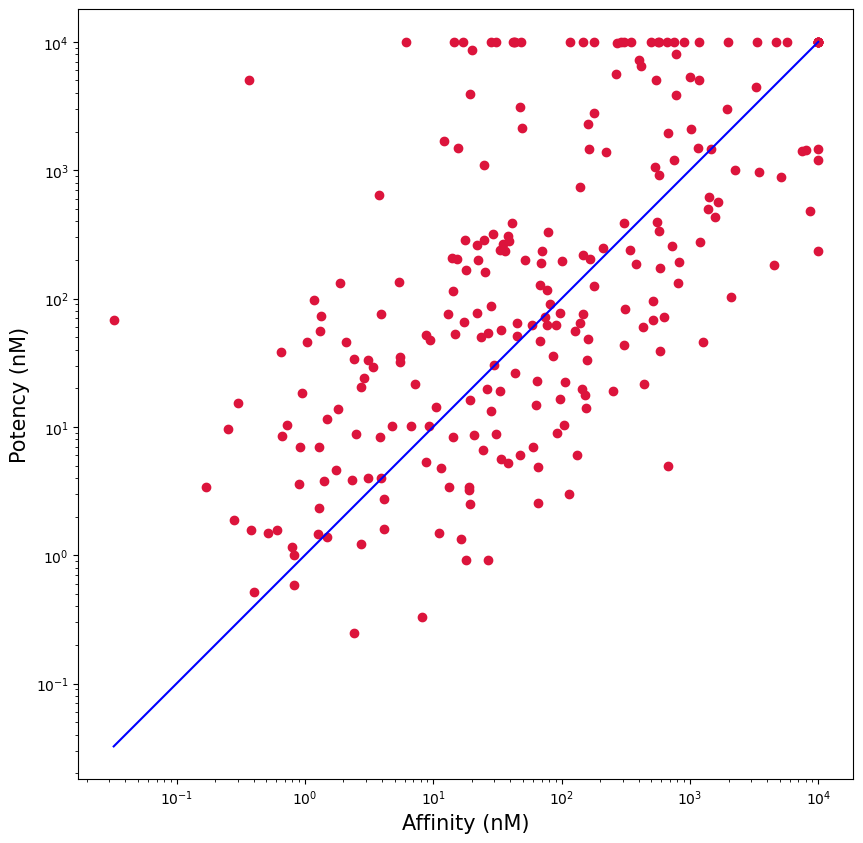

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(df['Ki'], df['ec50'], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(df['Ki']), max(df['ec50']))
p2 = min(min(df['Ki']), min(df['ec50']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Affinity (nM)', fontsize=15)
plt.ylabel('Potency (nM)', fontsize=15)
plt.axis('equal')

plt.show()

## Stats

Both sample are not from a Gaussian distribution

To test for correlation, we used the Spearman test, as data are non-normal
The Spearman test showed a positive correlation (ρ = 0.62, p < 0.001), indicating that higher values of Ki are associated with higher values of EC50 on a monotonic scale, even without assuming normality of the data.

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(pivoted['Ki'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
stat, p = shapiro(pivoted['ec50'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [ ]:
from scipy.stats import spearmanr

spearman_corr, spearman_p = spearmanr(pivoted['Ki'], pivoted['ec50'])

print(f"Spearman ρ = {spearman_corr:.3f}, p = {spearman_p:.3e}")

count = len(pivoted['Ki'])

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(spearman_corr) - delta)
upper = math.tanh(math.atanh(spearman_corr) + delta)

print(lower)
print(upper)